# Spatial Interaction Modelling from scratch
This notebook shows the strength of configuring model parameters using a generalized linear model with an underlying Poisson distribution

In [203]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pylab as plt
from sklearn.metrics import r2_score
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
sns.set(context='notebook', style='whitegrid', palette='deep', font='DejaVu Sans', font_scale=1.2, rc=None)
%matplotlib inline

### Import Flow Data

In [204]:
#import flow model csv
flow = pd.read_csv('data/FlowData.csv')
flow.drop('Unnamed: 0',axis=1,inplace=True)
flow.head(3)

,StartTAZ,FinishTAZ,AverageFare,AverageTime,AverageDistance,TotalPassengers,OriginPopulation,DestinationBars,StartPoint,FinishPoint
0,3600500000200,3606100006800,20.0,1028.0,6.40,1,4888.0,36,POINT (-73.86000330820553 40.80588752047242),POINT (-73.9840802591542 40.74043661734395)
1,3600500001900,3606100006800,24.5,1731.0,7.25,2,1941.0,36,POINT (-73.90958766603121 40.80124256559512),POINT (-73.9840802591542 40.74043661734395)
2,3600500002300,3606100006800,4.5,150.0,0.90,1,5459.0,36,POINT (-73.9258461389568 40.80908431818972),POINT (-73.9840802591542 40.74043661734395)


In [205]:
#convert 0 values to nonzero for interaction model to work
flow['OriginPopulation'][flow.OriginPopulation == 0.0] = 1

#eliminate airport and outliers
flow = flow[(flow.AverageTime > 10)&(flow.AverageFare > 0.00)&(flow.AverageDistance > 0.01) & (flow.StartTAZ != 3608100071600)& (flow.FinishTAZ != 3608100071600)] 

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Test which would be a better measure of cost (distance, average fare, or average time) 

Visualize each relationship to the total amount of 'flow' (TotalPassengers)

(0, 20)

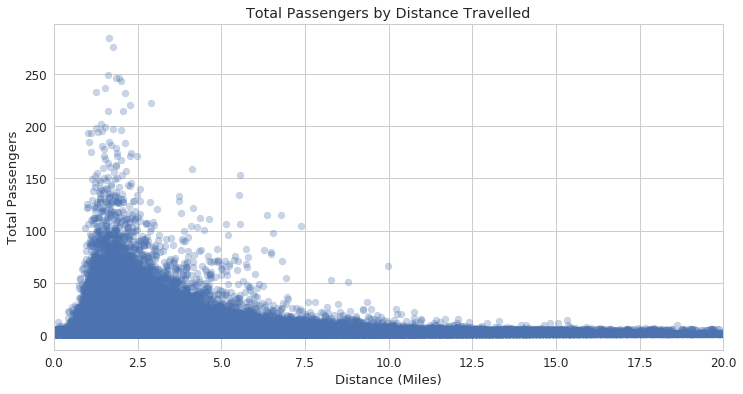

In [206]:
#Plot Distance and Total Passengers
plt.figure(figsize=(12,6))
plt.title('Total Passengers by Distance Travelled')
plt.scatter(flow.AverageDistance,flow.TotalPassengers,linewidths=0.25,alpha=0.3)
plt.xlabel('Distance (Miles)')
plt.ylabel('Total Passengers')
plt.xlim(0,20)

(0, 100)

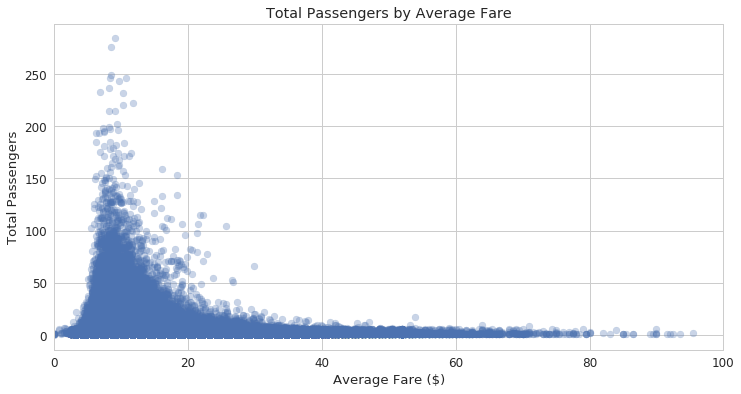

In [207]:
#Plot Distance and Total Passengers
plt.figure(figsize=(12,6))
plt.title('Total Passengers by Average Fare')
plt.scatter(flow.AverageFare,flow.TotalPassengers,linewidths=0.25,alpha=0.3)
plt.xlabel('Average Fare ($)')
plt.ylabel('Total Passengers')
plt.xlim(0,100)

(0, 5000)

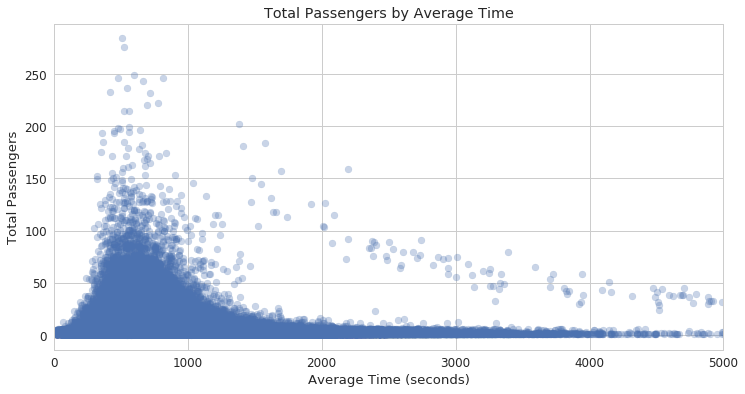

In [208]:
#Plot Time and Total Passengers
plt.figure(figsize=(12,6))
plt.title('Total Passengers by Average Time')
plt.scatter(flow.AverageTime,flow.TotalPassengers,linewidths=0.25,alpha=0.3)
plt.xlabel('Average Time (seconds)')
plt.ylabel('Total Passengers')
plt.xlim(0,5000)

#### Costs Conclusion:
Distance and Average Fare seem to be similar, whereas average time is not as positively skewed. All plots seem to follow a Poisson Distribution

## Spatial Interaction Model - Uncontrained

$T_{ij}=k*V_i^μ*W_j^α*d_{ij}^{-β}$

**This model just says that the flows between an origin and destination are proportional to the product of the mass of the origin and destination and inversely proportional to the distance between them.**

**As origin and destination masses increase, flows increase, but as distance increases, flows decrease, and vice versa.**
* where $T_{ij}$ is the transition or flow, $T$, between origin $i$ (always the rows in a matrix) and destination $j$ (always the columns in a matrix). If you are not overly familiar with matrix notation, the $i$ and $j$ are just generic indexes to allow us to refer to any cell in the matrix more generally.
* $V$ is a vector (a 1 dimensional matrix - or, if you like, a single line of numbers) of origin attributes which relate to the emissiveness of all origins in the dataset, i - in our sample dataset, we have a vector of origin populations (which I have called 'OriginPopulation') 
* $W$ is a vector of desination of attributes relating to the attractivenss of all destinations in the dataset, $j$ - in our sample dataset, we have a vector of Total Bars (which I have called 'TotalBars') 
* $d$ is a matrix of costs relating to the flows between i and j - in our case the cost is distance and it is called ‘AverageDistance’ in our dataset.
* $k, μ, α$ and $β$ are all model parameters to be estimated

source: https://rpubs.com/adam_dennett/376877

#### Estimate flow estimates using Equation above

In [209]:
mu, alpha, beta, k , T2 = 1,1,-2,1,flow.TotalPassengers.sum()

In [210]:
vi1_mu = flow.OriginPopulation**mu
wj3_alpha = flow.DestinationBars**alpha
dist_beta = flow.AverageTime**beta
T1 = vi1_mu*wj3_alpha*dist_beta
k = T2/sum(T1)
flow['unconstrainedEst'] = round(k*vi1_mu*wj3_alpha*dist_beta,0)

In [211]:
flow.head(5)

,StartTAZ,FinishTAZ,AverageFare,AverageTime,AverageDistance,TotalPassengers,OriginPopulation,DestinationBars,StartPoint,FinishPoint,unconstrainedEst
0,3600500000200,3606100006800,20.000000,1028.000000,6.40,1,4888.0,36,POINT (-73.86000330820553 40.80588752047242),POINT (-73.9840802591542 40.74043661734395),2.0
1,3600500001900,3606100006800,24.500000,1731.000000,7.25,2,1941.0,36,POINT (-73.90958766603121 40.80124256559512),POINT (-73.9840802591542 40.74043661734395),0.0
2,3600500002300,3606100006800,4.500000,150.000000,0.90,1,5459.0,36,POINT (-73.9258461389568 40.80908431818972),POINT (-73.9840802591542 40.74043661734395),122.0
3,3600500002500,3606100006800,21.166667,1076.333333,6.70,4,5886.0,36,POINT (-73.92087816464176 40.80700286223013),POINT (-73.9840802591542 40.74043661734395),3.0
4,3600500004100,3606100006800,9.333333,487.000000,2.48,9,6444.0,36,POINT (-73.91940998857129 40.81138557966759),POINT (-73.9840802591542 40.74043661734395),14.0


### Goodness of Fit

Calculate $R^2$ Value of Model to see how well it fits

In [212]:
r2_score(flow.TotalPassengers,flow.unconstrainedEst)

-126.49487124113391

In [213]:
#Try Pearsons R instead
sp.stats.pearsonr(flow.TotalPassengers,flow.unconstrainedEst)

(-0.0046982338648706478, 0.083551133308963799)

**Conclusion**: Obviously, this was a bust! What's left is to adjust the paramaters and see if we can do better

### Calibrate Parameters using a Poisson Regression Model

This portion was handled in R.

In [214]:
# Export to R for GLM regression
# flow.to_csv('data/FlowRefined.csv')

In [225]:
# GLM using Poisson summary model
uncosim = smf.glm('TotalPassengers ~ np.log(OriginPopulation) + np.log(DestinationBars) + np.log(AverageDistance)',flow,missing='drop',family=sm.families.Poisson()).fit()
summary = uncosim.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        TotalPassengers   No. Observations:               135659
Model:                            GLM   Df Residuals:                   135655
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -7.9082e+05
Date:                Sun, 25 Nov 2018   Deviance:                   1.1762e+06
Time:                        00:34:30   Pearson chi2:                 2.21e+06
No. Iterations:                     9                                         
============================================================================================
                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                    0.4381      0.010     42.893      0.000         0.418     0.458
np.log(OriginPopulation)     0.0692      0.001     61.187      0.000         0.067     0.071
np.log(DestinationBars)      0.4267      0.001    312.714      0.000         0.424     0.429
np.log(AverageDistance)     -0.3235      0.001   -236.519      0.000        -0.326    -0.321
============================================================================================
"""

In [228]:
k = 0.4381
mu = 0.0692
alpha = 0.426
beta = -0.3235

In [229]:
vi1_mu = flow.OriginPopulation**mu
wj3_alpha = flow.DestinationBars**alpha
dist_beta = flow.AverageTime**beta
T1 = vi1_mu*wj3_alpha*dist_beta
k = T2/sum(T1)
flow['unconstrainedEst2'] = round(k*vi1_mu*wj3_alpha*dist_beta,0)
r2_score(flow.TotalPassengers,flow.unconstrainedEst2)

0.037688710311266527

## Constrained Models
by constraining by our origin and destination categories, our total sum will be more accurate for each?

In [234]:
flow['Orig_code'] = flow.StartTAZ.astype(str)
flow['Dest_code'] = flow.FinishTAZ.astype(str)
flow.head()

,StartTAZ,FinishTAZ,AverageFare,AverageTime,AverageDistance,TotalPassengers,OriginPopulation,DestinationBars,StartPoint,FinishPoint,unconstrainedEst,unconstrainedEst2,Orig_code,Dest_code
0,3600500000200,3606100006800,20.000000,1028.000000,6.40,1,4888.0,36,POINT (-73.86000330820553 40.80588752047242),POINT (-73.9840802591542 40.74043661734395),2.0,8.0,3600500000200,3606100006800
1,3600500001900,3606100006800,24.500000,1731.000000,7.25,2,1941.0,36,POINT (-73.90958766603121 40.80124256559512),POINT (-73.9840802591542 40.74043661734395),0.0,7.0,3600500001900,3606100006800
2,3600500002300,3606100006800,4.500000,150.000000,0.90,1,5459.0,36,POINT (-73.9258461389568 40.80908431818972),POINT (-73.9840802591542 40.74043661734395),122.0,15.0,3600500002300,3606100006800
3,3600500002500,3606100006800,21.166667,1076.333333,6.70,4,5886.0,36,POINT (-73.92087816464176 40.80700286223013),POINT (-73.9840802591542 40.74043661734395),3.0,8.0,3600500002500,3606100006800
4,3600500004100,3606100006800,9.333333,487.000000,2.48,9,6444.0,36,POINT (-73.91940998857129 40.81138557966759),POINT (-73.9840802591542 40.74043661734395),14.0,11.0,3600500004100,3606100006800


### The following GLM's are best done in R
Allowing them to run on your local machine (vs. a virtual environment) is a good idea. Though the code is more or less the same,  I had better luck with the R Studio than Python. The code is much more resource intensive than our unconstrained model, and has something to do with introducing our categorical variables. 

In [ ]:
# prodSim = smf.glm('TotalPassengers ~ Orig_code + np.log(DestinationBars) + np.log(AverageDistance)-1',flow,missing='drop',family=sm.families.Poisson()).fit()
# prodSim.summary()

In [ ]:
# attrSim = smf.glm('TotalPassengers ~ Dest_code + np.log(OriginPopulation) + np.log(AverageDistance)-1',flow,missing='drop',family=sm.families.Poisson()).fit()
# attrSim.summary()

In [ ]:
# doubSim = smf.glm('TotalPassengers ~ Orig_code + Dest_code + np.log(AverageDistance)',flow,missing='drop',family=sm.families.Poisson()).fit()
# doubSim.summary()

### These values were derived through R using the same formulas as above

In [241]:
flowFinal = pd.read_csv('data/FlowDataFinal2.csv',usecols=['AverageDistance', 'TotalPassengers', 'OriginPopulation',
       'DestinationBars', 'Orig_code', 'Dest_code', 'prodsimFitted',
       'attrsimFitted', 'doubsimFitted', 'unconstrainedSim'])
flowFinal.head()

,AverageDistance,TotalPassengers,OriginPopulation,DestinationBars,Orig_code,Dest_code,prodsimFitted,attrsimFitted,doubsimFitted,unconstrainedSim
0,6.40,1,4888,36,3600500000200,3606100006800,3,7,3,7
1,7.25,2,1941,36,3600500001900,3606100006800,4,7,3,6
2,0.90,1,5459,36,3600500002300,3606100006800,3,16,3,13
3,6.70,4,5886,36,3600500002500,3606100006800,4,7,4,7
4,2.48,9,6444,36,3600500004100,3606100006800,3,11,3,10


In [244]:
# Unconstrained
r2_score(flowFinal.TotalPassengers,flowFinal.unconstrainedSim)

0.053356958695798262

In [245]:
# Production constrained
r2_score(flowFinal.TotalPassengers,flowFinal.prodsimFitted)

0.49526376814715933

In [247]:
# Attraction constrained
r2_score(flowFinal.TotalPassengers,flowFinal.attrsimFitted)

0.10788725644216246

In [248]:
# Doubly constrained
r2_score(flowFinal.TotalPassengers,flowFinal.doubsimFitted)

0.80239032202541538

## Conclusion - Doubly Constrained is the Best Fit